In [34]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver



In [35]:
R_eff = 4  # effective radius of the bend
A = 2.4  # clothoid parameter


In [36]:
L_max = 0  # starting point of L_max
precision = 0.05  # increasement of L_max at each iteration
tolerance = 0.01  # difference tolerance of the derivatives

# determine L_max
while True:
    L_max = L_max + precision  # update L_max
    Ls = np.linspace(0, L_max, 50)  # L at (x1,y1)
    x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
    y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve

    # compute x1 and y1 using the above integral equations
    for i, L in enumerate(Ls):
        y1[i], err = integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)
        x1[i], err = integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)

    # compute the derivative at L_max
    k = -(x1[-1] - x1[-2]) / (y1[-1] - y1[-2])
    xp = x1[-1]
    yp = y1[-1]
    # check if the derivative is continuous at L_max
    R = np.sqrt(
        ((R_eff + k * xp - yp) / (k + 1) - xp) ** 2
        + (-(R_eff + k * xp - yp) / (k + 1) + R_eff - yp) ** 2
    )
    if np.abs(R - A**2 / L_max) < tolerance:
        break

# after L_max is determined, R_min is also determined
R_min = A**2 / L_max


In [37]:
# getting the coordinates of the second clothoid curve by mirroring the first curve with respect to y=-x+R_eff
x3 = np.flipud(R_eff - y1)
y3 = np.flipud(R_eff - x1)


In [38]:
# solve for the parameters of the circular curve
def circle(var):
    a = var[0]
    b = var[1]
    Func = np.empty((2))
    Func[0] = (xp - a) ** 2 + (yp - b) ** 2 - R_min**2
    Func[1] = (R_eff - yp - a) ** 2 + (R_eff - xp - b) ** 2 - R_min**2
    return Func


a, b = fsolve(circle, (0, R_eff))

# calculate the coordinates of the circular curve
x2 = np.linspace(xp + 0.01, R_eff - yp - 0.01, 50)
y2 = -np.sqrt(R_min**2 - (x2 - a) ** 2) + b


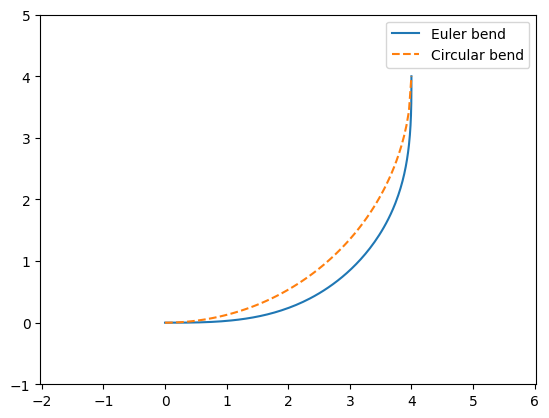

In [39]:
# obtain the coordinates of the whole Euler bend by concatenating three pieces together
x_euler = np.concatenate((x1, x2, x3))
y_euler = np.concatenate((y1, y2, y3))

# the conventional circular bend is simply given by a circle
x_circle = np.linspace(0, R_eff, 100)
y_circle = -np.sqrt(R_eff**2 - (x_circle) ** 2) + R_eff

# plotting the shapes of the Euler bend and the circular bend
plt.plot(x_euler, y_euler, label="Euler bend")
plt.plot(x_circle, y_circle, "--", label="Circular bend")
plt.axis("equal")
plt.ylim(-1, R_eff + 1)
plt.legend()
plt.show()


In [40]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 100)  # simulation wavelength range
freqs = td.C_0 / ldas  # simulation wavelength range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # frequency width of the souce


In [49]:
t = 0.2  # thickness of the waveguide
w = 0.4  # width of the waveguide
inf_eff = 100  # effective infinity of the simulation
buffer = 1  # buffer distance


In [91]:
#n_si = 3.476  # silicon refractive index
n_si = 4 # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.444  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


In [92]:
# function that takes the x and y coordinates of a curve and returns a waveguide bend structure with a given width and thickness
def line_to_structure(x, y, w, t):

    cell = gdstk.Cell("bend") # define a gds cell

    # add points to include the input and output straght waveguides
    x = np.insert(x, 0, -inf_eff)
    x = np.append(x, R_eff)
    y = np.insert(y,0,0)
    y = np.append(y, inf_eff)

    cell.add(gdstk.FlexPath(x + 1j * y, w, layer=1, datatype=0)) # add path to cell

    # define structure from cell
    bend = td.Structure(
        geometry=td.PolySlab.from_gds(
            cell,
            gds_layer=1,
            axis=2,
            slab_bounds=(0, t),
        )[0],
        medium=si
    )

    return bend


In [93]:
circular_bend = line_to_structure(x_circle, y_circle, w, t)


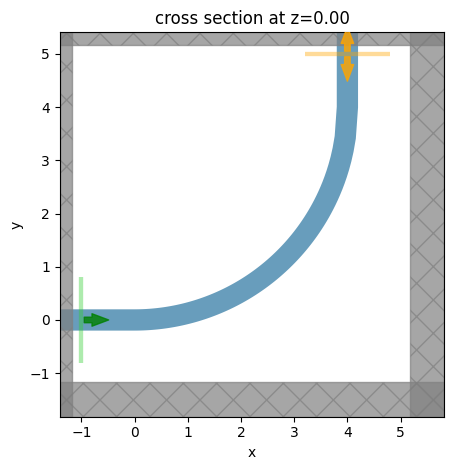

In [94]:
# add a mode source that launches the fundamental te mode
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-buffer, 0, t / 2),
    size=(0, 4 * w, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission
mode_monitor = td.ModeMonitor(
    center=(R_eff, R_eff + buffer, t / 2),
    size=(4 * w, 0, 6 * t),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)


# add a field monitor to visualize field propagation and leakage in the bend
field_monitor = td.FieldMonitor(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    colocate=True,
    name="field",
)


run_time = 5e-13  # simulation run time

# define simulation
sim = td.Simulation(
    center=(R_eff / 2, R_eff / 2, t / 2),
    size=(R_eff + 2 * w + lda0, R_eff + 2 * w + lda0, 10 * t),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[circular_bend],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    medium=sio2,
)  # background medium is set to sio2 because of the substrate and upper cladding

# visualize the circular bend structure
sim.plot(z=0)
plt.show()


In [95]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(-buffer, 0, t / 2), size=(0, 4 * w, 6 * t)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

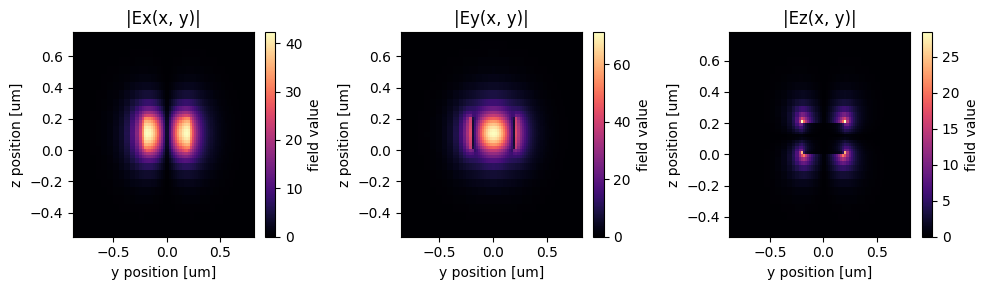

In [96]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="y", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="y", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="y", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax2.set_title("|Ey(x, y)|")
ax3.set_title("|Ez(x, y)|")
plt.show()